# Example notebook using R 


import libraries and load dataset

In [1]:
rm(list=ls())
library(gbm)
library(parallel)
library(caret)

Loaded gbm 2.1.8

Loading required package: ggplot2

Loading required package: lattice



## Prepare mlflow 

In [2]:
library(mlflow)
system('az login --identity')

new_tracking_uri = sub('azureml://', 'https://', mlflow_get_tracking_uri()) 

BEARER_TOKEN <- system('az account get-access-token --query accessToken -o tsv', intern = TRUE)

Sys.setenv('MLFLOW_TRACKING_URI'=new_tracking_uri)
Sys.setenv('MLFLOW_TRACKING_TOKEN'= BEARER_TOKEN)

print(Sys.getenv('MLFLOW_TRACKING_URI'))
print(substr(Sys.getenv('MLFLOW_TRACKING_TOKEN'), 1, 30))

[1] "https://australiaeast.api.azureml.ms/mlflow/v1.0/subscriptions/907c8efc-c2c8-4c49-a4e1-aeb880e10c88/resourceGroups/azureml/providers/Microsoft.MachineLearningServices/workspaces/magazureml"
[1] "eyJ0eXAiOiJKV1QiLCJhbGciOiJSUz"


## read dataset

In [3]:
# Read in and format our data
wine_data <- read.csv("wines.csv")
str(wine_data)


'data.frame':	6497 obs. of  14 variables:
 $ ID                  : int  1 2 3 4 5 6 7 8 9 10 ...
 $ fixed.acidity       : num  7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 7.5 ...
 $ volatile.acidity    : num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric.acid         : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual.sugar      : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ chlorides           : num  0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.071 ...
 $ free.sulfur.dioxide : num  11 25 15 17 11 13 15 15 9 17 ...
 $ total.sulfur.dioxide: num  34 67 54 60 34 40 59 21 18 102 ...
 $ density             : num  0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num  3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.35 ...
 $ sulphates           : num  0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.8 ...
 $ alcohol             : num  9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 10.5 ...
 $ quality             : int  5 5 5 6 5 5 5 7 7 5 ...
 $ colour              : chr

## data preperation

In [4]:
#convert colour to factor
wine_data$colour <- as.factor(wine_data$colour)

# Drop the ID column
wine_data$ID <- NULL

# Let's make this a binary classification
wine_data$quality_binary <- 1
wine_data[wine_data$quality < 7, "quality_binary"] <- 0

# Need to drop the quality predictor
wine_data$quality <- NULL


   0    1 
5220 1277 


        0         1 
0.8034477 0.1965523 

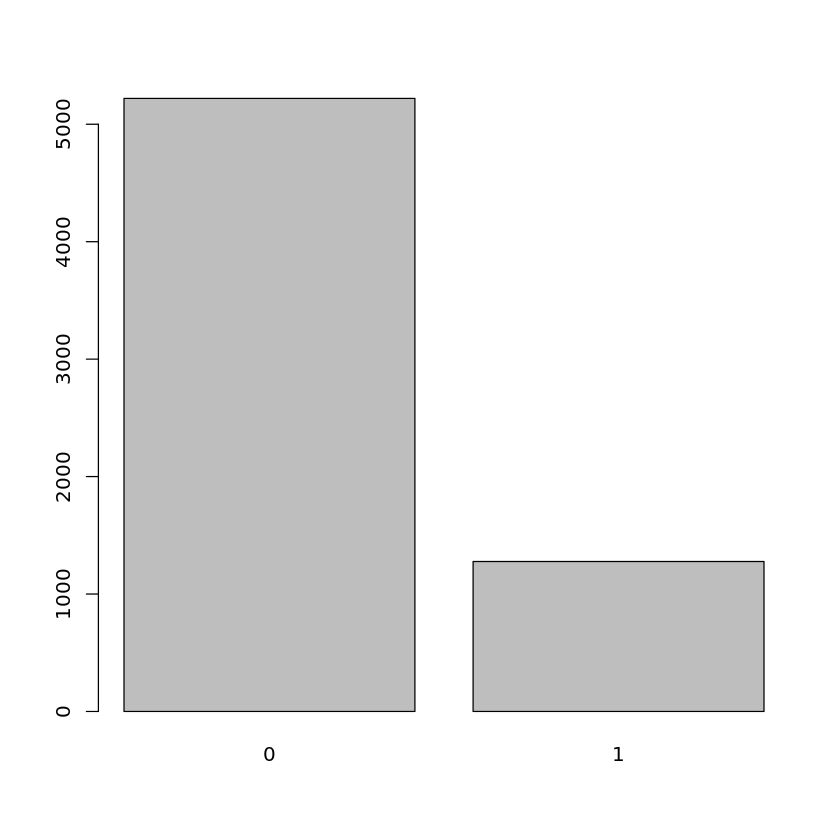

In [5]:
# Our dataset is a little imbalanced but not too bad.
table_1 <- table(wine_data$quality_binary)
table_1
prop.table(table_1) 
barplot(table_1)

## Training

In [6]:
# Create training and test sets. This process should be familiar by now
trainset_size <- floor(0.80 * nrow(wine_data))
set.seed(1) 
trainset_indices <- sample(seq_len(nrow(wine_data)), size = trainset_size)
training <- wine_data[trainset_indices, ]
testset <- wine_data[-trainset_indices, ]

In [7]:
# Checks
mlflow_log_metric('training set size', nrow(training))
mlflow_log_metric('test set size', nrow(testset)) 
mlflow_log_metric('data set size', nrow(wine_data))

In [8]:
# Defining some parameters

gbm_depth = 2 #maximum nodes per tree
gbm_n_min = 20 #minimum number of observations in the trees terminal, important effect on overfitting
gbm_shrinkage=0.01 #learning rate
cores_num = detectCores() - 1 #number of cores. Leave 1 for OS. Beware this setting!
gbm_cv_folds=5 #number of cross-validation folds to perform
num_trees = 200 # Number of iterations



In [9]:

params = data.frame(
    key = c('gbm_depth', 'gbm_n_min', 'gbm_shrinkage', 'cores_num', 'gbm_cv_folds', 'num_trees'), 
    value = c(gbm_depth, gbm_n_min, gbm_shrinkage, cores_num, gbm_cv_folds, num_trees)
)
mlflow_log_batch(
    params = params
)


In [10]:
start <- proc.time()

# fit initial model
gbm_clf = gbm(training$quality_binary~.,
                  data=training[, -ncol(training)],
                  distribution='bernoulli', #binary response
                  n.trees=num_trees,
                  interaction.depth= gbm_depth,
                  n.minobsinnode = gbm_n_min, 
                  shrinkage=gbm_shrinkage, 
                  cv.folds=gbm_cv_folds,
                  verbose = TRUE, #print the preliminary output
                  n.cores = cores_num
)

end <- proc.time() - start

end_time <- as.numeric((paste(end[3])))


mlflow_log_metric('end_time', end_time)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.9915            -nan     0.0100    0.0015
     2        0.9882            -nan     0.0100    0.0015
     3        0.9850            -nan     0.0100    0.0015
     4        0.9820            -nan     0.0100    0.0015
     5        0.9790            -nan     0.0100    0.0014
     6        0.9762            -nan     0.0100    0.0014
     7        0.9734            -nan     0.0100    0.0014
     8        0.9706            -nan     0.0100    0.0013
     9        0.9679            -nan     0.0100    0.0013
    10        0.9654            -nan     0.0100    0.0012
    20        0.9411            -nan     0.0100    0.0010
    40        0.9044            -nan     0.0100    0.0007
    60        0.8779            -nan     0.0100    0.0005
    80        0.8585            -nan     0.0100    0.0003
   100        0.8435            -nan     0.0100    0.0002
   120        0.8308            -nan     0.0100    0.0003
   140        

## Explore Results

[1] 200


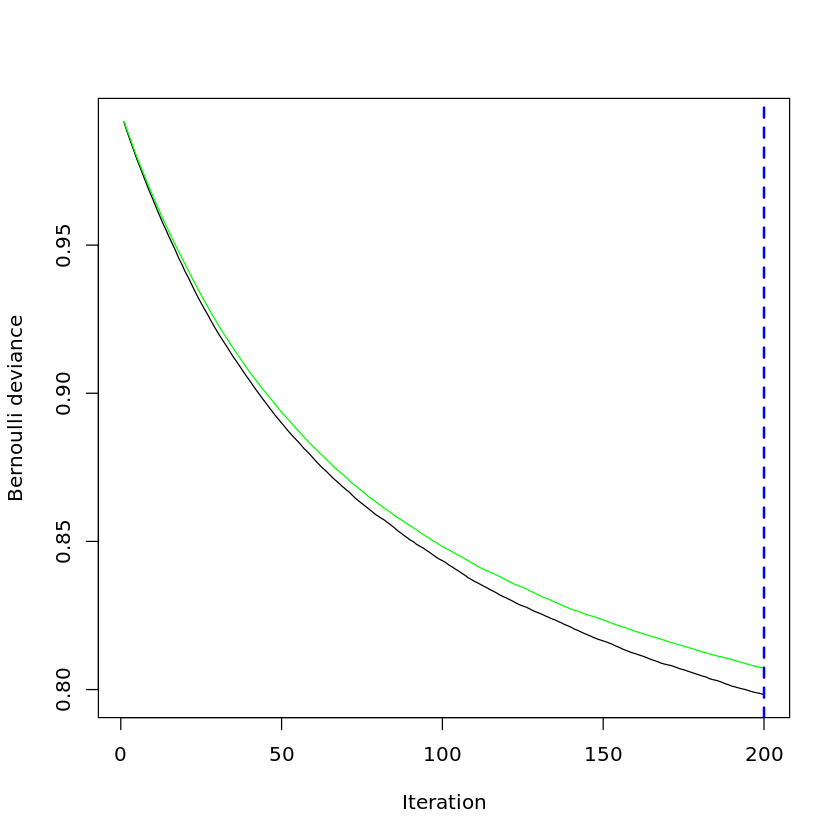

In [11]:
# Estimate the optimal number of iterations (when will the model stop improving)
# The black is the training deviance dropping whilst the green is the test.
best_iter = gbm.perf(gbm_clf, method = "cv")
print(best_iter)


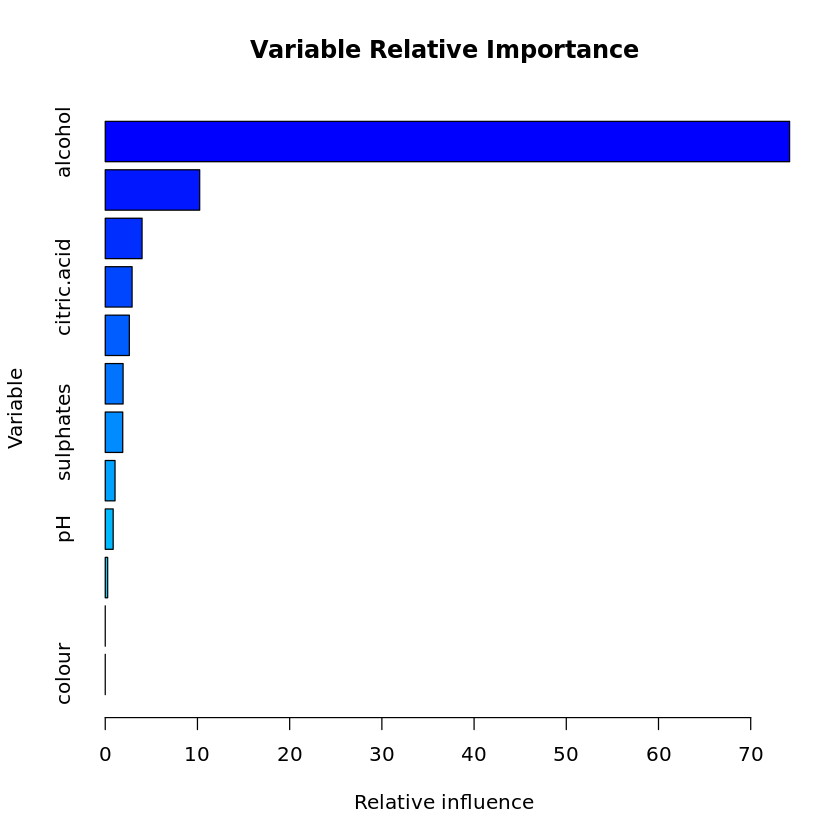

In [12]:
# Gives the variable importance in a graph
summary_gbm = summary(gbm_clf,n.trees=best_iter, ylab = "Variable", main = "Variable Relative Importance")


# OR just as a table
# summary(gbm_clf)

## Test model

In [13]:
# Let us get our estimates
testset$probability = predict(gbm_clf, testset, n.trees = best_iter, type = "response")
testset$prediction = 0

# Modify the probability threshold to see if you can get a better accuracy
testset[testset$probability >= 0.5, "prediction"] = 1


In [14]:
# Confusion matrix
confusion_matrix <- table(pred=testset$prediction,true=testset$quality_binary)
confusionMatrix(confusion_matrix)

Confusion Matrix and Statistics

    true
pred    0    1
   0 1033  226
   1   18   23
                                        
               Accuracy : 0.8123        
                 95% CI : (0.79, 0.8332)
    No Information Rate : 0.8085        
    P-Value [Acc > NIR] : 0.378         
                                        
                  Kappa : 0.1104        
                                        
 Mcnemar's Test P-Value : <2e-16        
                                        
            Sensitivity : 0.98287       
            Specificity : 0.09237       
         Pos Pred Value : 0.82049       
         Neg Pred Value : 0.56098       
             Prevalence : 0.80846       
         Detection Rate : 0.79462       
   Detection Prevalence : 0.96846       
      Balanced Accuracy : 0.53762       
                                        
       'Positive' Class : 0             
                                        

## log model performance metrics

In [18]:
cm <- confusionMatrix(confusion_matrix)
str(cm)

List of 6
 $ positive: chr "0"
 $ table   : 'table' int [1:2, 1:2] 1033 18 226 23
  ..- attr(*, "dimnames")=List of 2
  .. ..$ pred: chr [1:2] "0" "1"
  .. ..$ true: chr [1:2] "0" "1"
 $ overall : Named num [1:7] 0.812 0.11 0.79 0.833 0.808 ...
  ..- attr(*, "names")= chr [1:7] "Accuracy" "Kappa" "AccuracyLower" "AccuracyUpper" ...
 $ byClass : Named num [1:11] 0.9829 0.0924 0.8205 0.561 0.8205 ...
  ..- attr(*, "names")= chr [1:11] "Sensitivity" "Specificity" "Pos Pred Value" "Neg Pred Value" ...
 $ mode    : chr "sens_spec"
 $ dots    : list()
 - attr(*, "class")= chr "confusionMatrix"


In [33]:
for (name in attributes(cm$overall)$names) 
    mlflow_log_metric(name, cm$overall[name])


## end experiment run

In [36]:
mlflow_end_run()

run_uuid,experiment_id,user_id,status,start_time,end_time,artifact_uri,lifecycle_stage,run_id,metrics,params,tags
<chr>,<chr>,<chr>,<chr>,<dttm>,<dttm>,<chr>,<chr>,<chr>,<list>,<list>,<list>
65842778-39d3-4b98-89c7-eed8f5e48755,37100a77-4514-475e-a055-225f29ec6542,efd036e9-c0e2-435e-90a8-0b5e91d4eaf2,FINISHED,2022-04-16 09:55:22,2022-04-16 10:04:11,azureml://experiments/Default/runs/65842778-39d3-4b98-89c7-eed8f5e48755/artifacts,active,65842778-39d3-4b98-89c7-eed8f5e48755,"training set size , test set size , data set size , end_time , Accuracy , Kappa , AccuracyLower , AccuracyUpper , AccuracyNull , AccuracyPValue , McnemarPValue , 5197 , 1300 , 6497 , 4.405 , 0.812307692307692 , 0.110443039749623 , 0.790000244205857 , 0.833192989571106 , 0.808461538461538 , 0.378048411881726 , 4.40409275046511e-40, 1650102923.122 , 1650102923.796 , 1650102924.285 , 1650102929.211 , 1650103407.01 , 1650103412.507 , 1650103412.863 , 1650103413.395 , 1650103413.677 , 1650103413.937 , 1650103414.216","gbm_depth , gbm_n_min , gbm_shrinkage, cores_num , gbm_cv_folds , num_trees , 2 , 20 , 0.01 , 3 , 5 , 200","mlflow.user , mlflow.source.name , mlflow.source.type , mlflow.rootRunId , mlflow.runName , azureuser , <console> , LOCAL , 65842778-39d3-4b98-89c7-eed8f5e48755, icy_board_8kskxfr2"
